In [55]:
!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

Archive:  /content/VisDrone2019-DET-val.zip
replace /content/dataset/VisDrone2019-DET-val/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset/VisDrone2019-DET-val/.DS_Store  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03499_d_0000006.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03999_d_0000007.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_04527_d_0000008.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05249_d_0000009.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05499_d_0000010.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05999_d_0000011.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_07999_d_0000012.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/a

In [56]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.measure import label as skimage_label
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import shutil

In [57]:
IMAGES_DIR = "/content/processed_dataset/newimages"
ANNOTATIONS_DIR = "/content/processed_dataset/newannotations"

In [58]:
if not os.path.exists(IMAGES_DIR) or not os.listdir(IMAGES_DIR):
    print(f"Warning: {IMAGES_DIR} is empty or not found. Creating dummy files for demonstration.")
    os.makedirs(IMAGES_DIR, exist_ok=True)
    os.makedirs(ANNOTATIONS_DIR, exist_ok=True)
    for i in range(15):
        dummy_img_data = np.full((200, 300, 3), (i*15, i*10, i*5), dtype=np.uint8)
        cv2.putText(dummy_img_data, f"IMG {i}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        if i % 3 == 0:
            cv2.rectangle(dummy_img_data, (30,30), (80,70), (10,10,10), -1)
            cv2.rectangle(dummy_img_data, (100,100), (150,140), (20,20,20), -1)
        elif i % 3 == 1:
             cv2.rectangle(dummy_img_data, (50,80), (90,120), (5,5,5), -1)

        cv2.imwrite(os.path.join(IMAGES_DIR, f"example_image_{i}.jpg"), dummy_img_data)
        with open(os.path.join(ANNOTATIONS_DIR, f"example_image_{i}.txt"), "w") as f_handle:
            if i % 3 == 0:
                 f_handle.write(f"30,30,50,40,1,4,0,0\n")
                 f_handle.write(f"100,100,50,40,1,4,0,0\n")
            elif i % 3 == 1:
                 f_handle.write(f"50,80,40,40,1,4,0,0\n")
    print(f"Created dummy files in {IMAGES_DIR} and {ANNOTATIONS_DIR}")

In [59]:
class VehicleSegmenterAndCounter:
    def __init__(self, images_root_path, annotations_root_path, patch_source_filenames=None):
        self.img_dir = images_root_path
        self.ann_dir = annotations_root_path
        self.all_img_files = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not self.all_img_files:
            print(f"Critical Error: No image files found in the directory {self.img_dir}.")
            raise FileNotFoundError(f"No images in {self.img_dir}")

        self.knn_shape_classifier = None
        self.hu_moment_scaler = None
        self.color_ref_img = None
        self.patch_img_sources = patch_source_filenames if patch_source_filenames else []

        try:
            ref_path = os.path.join(self.img_dir, random.choice(self.all_img_files))
            self.color_ref_img = cv2.imread(ref_path)
            if self.color_ref_img is None:
                 print(f"Warning: Failed to load color reference image from {ref_path}.")
        except IndexError:
            print("Warning: Cannot load color reference image, image directory might be effectively empty for choices.")


    def _extract_log_scaled_hu_moments(self, binary_mask_of_contour):
        img_moments_data = cv2.moments(binary_mask_of_contour)
        hu_moments_vector = cv2.HuMoments(img_moments_data).flatten()
        processed_hu_vector = np.zeros_like(hu_moments_vector)
        for idx in range(len(hu_moments_vector)):
            value = hu_moments_vector[idx]
            if value == 0:
                processed_hu_vector[idx] = 0
            else:
                processed_hu_vector[idx] = -1 * np.copysign(1.0, value) * np.log10(abs(value) + 1e-7) # add epsilon
        return processed_hu_vector

    def _perform_watershed_segmentation(self, bgr_input_image):
        blurred_img = cv2.medianBlur(bgr_input_image, 3)
        grayscale_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)
        _, binary_threshold_img = cv2.threshold(grayscale_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        morph_kernel_op = np.ones((3,3), np.uint8)
        opened_img_morph = cv2.morphologyEx(binary_threshold_img, cv2.MORPH_OPEN, morph_kernel_op, iterations=2)

        sure_background_area = cv2.dilate(opened_img_morph, morph_kernel_op, iterations=3)
        distance_map_img = cv2.distanceTransform(opened_img_morph, cv2.DIST_L2, 5)
        _, sure_foreground_area = cv2.threshold(distance_map_img, 0.7 * distance_map_img.max(), 255, 0) # 0.7 factor
        sure_foreground_area = np.uint8(sure_foreground_area)
        unknown_zone = cv2.subtract(sure_background_area, sure_foreground_area)

        _, component_markers = cv2.connectedComponents(sure_foreground_area)
        component_markers = component_markers + 1
        component_markers[unknown_zone == 255] = 0
        final_segmented_markers = cv2.watershed(bgr_input_image, component_markers)
        return final_segmented_markers, grayscale_img

    def _compute_iou(self, rect_a, rect_b):
        ix1 = max(rect_a[0], rect_b[0])
        iy1 = max(rect_a[1], rect_b[1])
        ix2 = min(rect_a[2], rect_b[2])
        iy2 = min(rect_a[3], rect_b[3])
        intersection_w = max(0, ix2 - ix1)
        intersection_h = max(0, iy2 - iy1)
        intersection_area = intersection_w * intersection_h
        area_a = (rect_a[2] - rect_a[0]) * (rect_a[3] - rect_a[1])
        area_b = (rect_b[2] - rect_b[0]) * (rect_b[3] - rect_b[1])
        union_area = float(area_a + area_b - intersection_area)
        return intersection_area / union_area if union_area > 0 else 0

    def train_shape_classifier(self, training_filenames):
        feature_collection = []
        label_collection = []
        min_training_contour_px_area = 75

        for filename in training_filenames:
            img_file_path = os.path.join(self.img_dir, filename)
            ann_file_path = os.path.join(self.ann_dir, filename.rsplit('.',1)[0] + '.txt')

            if not os.path.exists(ann_file_path): continue
            input_bgr_img = cv2.imread(img_file_path)
            if input_bgr_img is None: continue

            segmented_map, gray_map = self._perform_watershed_segmentation(input_bgr_img)
            ground_truth_vehicle_rects = []
            with open(ann_file_path, 'r') as af_handle:
                for line_data in af_handle:
                    parts = line_data.strip().split(',')
                    if len(parts) >= 6 and int(parts[5]) == 4:
                        x, y, w, h = map(int, parts[:4])
                        ground_truth_vehicle_rects.append([x, y, x + w, y + h])

            unique_ids_in_map = np.unique(segmented_map)
            for unique_id in unique_ids_in_map:
                if unique_id in [-1, 0, 1]: continue

                current_id_mask = np.zeros(gray_map.shape, dtype=np.uint8)
                current_id_mask[segmented_map == unique_id] = 255
                region_contours, _ = cv2.findContours(current_id_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                for individual_contour in region_contours:
                    if cv2.contourArea(individual_contour) < min_training_contour_px_area: continue
                    clean_contour_mask = np.zeros(gray_map.shape, dtype=np.uint8)
                    cv2.drawContours(clean_contour_mask, [individual_contour], -1, 255, -1)
                    if cv2.countNonZero(clean_contour_mask) == 0: continue

                    hu_features = self._extract_log_scaled_hu_moments(clean_contour_mask)
                    x_b, y_b, w_b, h_b = cv2.boundingRect(individual_contour)
                    contour_rect = [x_b, y_b, x_b + w_b, y_b + h_b]
                    is_vehicle_label = 0
                    if ground_truth_vehicle_rects:
                        for gt_rect in ground_truth_vehicle_rects:
                            if self._compute_iou(contour_rect, gt_rect) > 0.4:
                                is_vehicle_label = 1
                                break
                    feature_collection.append(hu_features)
                    label_collection.append(is_vehicle_label)

        if not feature_collection:
            print("Error: No features were extracted for classifier training.")
            return False
        self.hu_moment_scaler = StandardScaler()
        scaled_features = self.hu_moment_scaler.fit_transform(np.array(feature_collection))
        self.knn_shape_classifier = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan')
        self.knn_shape_classifier.fit(scaled_features, np.array(label_collection))
        print(f"Shape classifier trained with {len(feature_collection)} samples.")
        return True

    def detect_vehicles_from_image(self, image_bgr_data):
        if self.knn_shape_classifier is None or self.hu_moment_scaler is None:
            print("Classifier is not ready. Please train it first.")
            return [], [], np.zeros(image_bgr_data.shape[:2], dtype=np.uint8)

        segmented_map, gray_map = self._perform_watershed_segmentation(image_bgr_data)
        final_vehicle_rects = []
        vehicle_hu_moment_list = []
        output_prediction_mask = np.zeros(image_bgr_data.shape[:2], dtype=np.uint8)
        min_detection_contour_px_area = 150
        detection_features = []
        candidate_rects = []
        candidate_hu_moments_raw = []

        unique_ids_in_map = np.unique(segmented_map)
        for unique_id in unique_ids_in_map:
            if unique_id in [-1, 0, 1]: continue
            current_id_mask = np.zeros(gray_map.shape, dtype=np.uint8)
            current_id_mask[segmented_map == unique_id] = 255
            region_contours, _ = cv2.findContours(current_id_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for individual_contour in region_contours:
                area_val = cv2.contourArea(individual_contour)
                x_c, y_c, w_c, h_c = cv2.boundingRect(individual_contour)
                aspect_ratio = w_c / (h_c + 1e-6)
                if not (area_val > min_detection_contour_px_area and \
                        25 < w_c < 380 and 25 < h_c < 380 and \
                        0.25 < aspect_ratio < 4.5):
                    continue

                clean_contour_mask = np.zeros(gray_map.shape, dtype=np.uint8)
                cv2.drawContours(clean_contour_mask, [individual_contour], -1, 255, -1)
                if cv2.countNonZero(clean_contour_mask) == 0: continue

                hu_set = self._extract_log_scaled_hu_moments(clean_contour_mask)
                detection_features.append(hu_set)
                candidate_rects.append([x_c, y_c, x_c + w_c, y_c + h_c])
                candidate_hu_moments_raw.append(hu_set)

        if detection_features:
            scaled_detection_features = self.hu_moment_scaler.transform(np.array(detection_features))
            class_predictions = self.knn_shape_classifier.predict(scaled_detection_features)
            nms_candidate_rects = []
            nms_candidate_scores = []
            nms_candidate_hu = []

            for i, pred_label in enumerate(class_predictions):
                if pred_label == 1:
                    nms_candidate_rects.append(candidate_rects[i])
                    nms_candidate_scores.append(0.95)
                    nms_candidate_hu.append(candidate_hu_moments_raw[i])

            if nms_candidate_rects:
                nms_rects_xywh = [[r[0], r[1], r[2]-r[0], r[3]-r[1]] for r in nms_candidate_rects]
                selected_after_nms_indices = cv2.dnn.NMSBoxes(nms_rects_xywh, nms_candidate_scores,
                                                              score_threshold=0.3, nms_threshold=0.4)
                if len(selected_after_nms_indices) > 0:
                    selected_after_nms_indices = selected_after_nms_indices.flatten()
                    print(f"Hu Moments for Detected Vehicles")
                    for sel_idx in selected_after_nms_indices:
                        vehicle_box = nms_candidate_rects[sel_idx]
                        final_vehicle_rects.append(vehicle_box)
                        hu_for_vehicle = nms_candidate_hu[sel_idx]
                        vehicle_hu_moment_list.append(hu_for_vehicle)
                        cv2.rectangle(output_prediction_mask, (vehicle_box[0], vehicle_box[1]),
                                      (vehicle_box[2], vehicle_box[3]), 255, -1)
                        print(f"  Vehicle at {vehicle_box}, Hu: {np.round(hu_for_vehicle, 4)}")
                    print(f"End Hu Moments")
        return final_vehicle_rects, vehicle_hu_moment_list, output_prediction_mask

    def _get_vehicle_patches(self, patch_image_file, patch_annotation_file):
        img_for_patches = cv2.imread(os.path.join(self.img_dir, patch_image_file))
        if img_for_patches is None: return []
        if self.color_ref_img is not None:
            img_for_patches = apply_color_matching(img_for_patches, self.color_ref_img)

        extracted_patches = []
        full_ann_path = os.path.join(self.ann_dir, patch_annotation_file)
        if os.path.exists(full_ann_path):
            with open(full_ann_path, 'r') as f_patch_ann:
                for line_item in f_patch_ann:
                    elements = line_item.strip().split(',')
                    if len(elements) >= 6 and int(elements[5]) == 4:
                        x,y,w,h = map(int, elements[:4])
                        if w > 10 and h > 10:
                            patch_data = img_for_patches[y:y+h, x:x+w]
                            if patch_data.size > 0:
                                extracted_patches.append(patch_data)
        return extracted_patches

    def generate_composite_image(self, base_bg_filename, max_added_patches=3, max_obj_overlap=0.2):
        base_bg_img = cv2.imread(os.path.join(self.img_dir, base_bg_filename))
        if base_bg_img is None: return None, []
        if self.color_ref_img is not None:
            base_bg_img = apply_color_matching(base_bg_img, self.color_ref_img)

        base_bg_ann_filename = base_bg_filename.rsplit('.',1)[0] + '.txt'
        all_gt_boxes_in_composite = []
        full_base_ann_path = os.path.join(self.ann_dir, base_bg_ann_filename)
        if os.path.exists(full_base_ann_path):
            with open(full_base_ann_path, 'r') as f_base_ann:
                for line_item in f_base_ann:
                    elements = line_item.strip().split(',')
                    if len(elements) >= 6 and int(elements[5]) == 4:
                        x,y,w,h = map(int, elements[:4])
                        all_gt_boxes_in_composite.append([x,y,x+w,y+h])

        available_vehicle_patches = []
        patch_source_pool = [f for f in self.patch_img_sources if f != base_bg_filename]
        if not patch_source_pool:
            patch_source_pool = [f for f in self.all_img_files if f != base_bg_filename]

        if not patch_source_pool: return base_bg_img.copy(), list(all_gt_boxes_in_composite)

        num_patch_sources_to_sample = min(len(patch_source_pool), 3)
        for patch_src_img_file in random.sample(patch_source_pool, num_patch_sources_to_sample):
            patch_src_ann_file = patch_src_img_file.rsplit('.',1)[0] + '.txt'
            available_vehicle_patches.extend(self._get_vehicle_patches(patch_src_img_file, patch_src_ann_file))

        if not available_vehicle_patches: return base_bg_img.copy(), list(all_gt_boxes_in_composite)

        current_composite_img = base_bg_img.copy()
        patches_to_place_count = random.randint(1, max(1, max_added_patches))

        for _ in range(patches_to_place_count):
            if not available_vehicle_patches: break
            chosen_patch = random.choice(available_vehicle_patches)
            patch_h_orig, patch_w_orig = chosen_patch.shape[:2]
            resize_scale = random.uniform(0.5, 1.2)
            new_w, new_h = int(patch_w_orig * resize_scale), int(patch_h_orig * resize_scale)
            if new_w < 10 or new_h < 10: continue
            resized_chosen_patch = cv2.resize(chosen_patch, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

            for _try_placement in range(20):
                place_x = random.randint(0, current_composite_img.shape[1] - new_w - 1)
                place_y = random.randint(0, current_composite_img.shape[0] - new_h - 1)
                new_box_coords = [place_x, place_y, place_x + new_w, place_y + new_h]
                placement_valid = True
                for existing_box_coords in all_gt_boxes_in_composite:
                    if self._compute_iou(new_box_coords, existing_box_coords) > max_obj_overlap:
                        placement_valid = False
                        break
                if placement_valid:
                    blend_mask = 255 * np.ones(resized_chosen_patch.shape[:2], dtype=resized_chosen_patch.dtype)
                    blend_center = (place_x + new_w // 2, place_y + new_h // 2)
                    if 0 < blend_center[0] < current_composite_img.shape[1] and \
                       0 < blend_center[1] < current_composite_img.shape[0]:
                        try:
                            current_composite_img = cv2.seamlessClone(resized_chosen_patch, current_composite_img,
                                                                      blend_mask, blend_center, cv2.MIXED_CLONE) # MIXED_CLONE
                            all_gt_boxes_in_composite.append(new_box_coords)
                            break
                        except cv2.error:
                            pass
        return current_composite_img, all_gt_boxes_in_composite


In [60]:
NUM_TEST_IMAGES = 10
USE_SYNTHETIC_IMAGES_FOR_TESTING = False
NUM_PATCHES_MAX_SYNTHETIC = 3
SYNTHETIC_IMAGE_MAX_OVERLAP_RATIO = 0.2

In [61]:
def calculate_color_statistics(image_matrix):
    mean_values, std_dev_values = cv2.meanStdDev(image_matrix)
    return mean_values.flatten(), std_dev_values.flatten()

def apply_color_matching(target_image, reference_template_image):
    target_mean, target_std = calculate_color_statistics(target_image)
    reference_mean, reference_std = calculate_color_statistics(reference_template_image)
    target_std[target_std < 1e-5] = 1e-5
    reference_std[reference_std < 1e-5] = 1e-5

    corrected_image_data = target_image.astype(np.float32)
    for channel_idx in range(corrected_image_data.shape[2]):
        corrected_image_data[:,:,channel_idx] = ((corrected_image_data[:,:,channel_idx] - target_mean[channel_idx]) * \
                                                 (reference_std[channel_idx] / target_std[channel_idx])) + \
                                                 reference_mean[channel_idx]
    return np.clip(corrected_image_data, 0, 255).astype(np.uint8)

In [62]:
all_image_filenames_main = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(all_image_filenames_main)

training_files_list_main = []
source_files_for_testing_main = []
actual_num_test_images_main = 0

if not all_image_filenames_main:
    print("CRITICAL: IMAGES_DIR is empty. Cannot proceed with training or testing.")
else:
    if len(all_image_filenames_main) <= NUM_TEST_IMAGES :
        print(f"Warning: Total images ({len(all_image_filenames_main)}) is less than or equal to NUM_TEST_IMAGES ({NUM_TEST_IMAGES}).")
        training_files_list_main = all_image_filenames_main[:1] if all_image_filenames_main else []
        source_files_for_testing_main = list(all_image_filenames_main) #
        actual_num_test_images_main = len(source_files_for_testing_main)
    else:
        num_train = max(1, min(int(len(all_image_filenames_main) * 0.20), 10))
        training_files_list_main = all_image_filenames_main[:num_train]
        remaining_files_for_test = all_image_filenames_main[num_train:]
        source_files_for_testing_main = remaining_files_for_test[:NUM_TEST_IMAGES]
        actual_num_test_images_main = len(source_files_for_testing_main)
        if actual_num_test_images_main < NUM_TEST_IMAGES:
             print(f"Warning: After splitting, only {actual_num_test_images_main} images available for testing.")

vehicle_processor = VehicleSegmenterAndCounter(IMAGES_DIR, ANNOTATIONS_DIR, training_files_list_main)
classifier_is_ready = False

if training_files_list_main:
    print(f"Starting classifier training with {len(training_files_list_main)} image(s): {training_files_list_main}")
    classifier_is_ready = vehicle_processor.train_shape_classifier(training_files_list_main)
    if not classifier_is_ready:
        print("Classifier training process completed but indicated failure or no data. Evaluation may be compromised.")
else:
    print("No files designated for training. Classifier will not be trained.")

print(f"Testing will be performed on {actual_num_test_images_main} image(s).")
if USE_SYNTHETIC_IMAGES_FOR_TESTING:
    print(f"Test images will be synthetically generated using base images from: {source_files_for_testing_main[:3]}... (up to {actual_num_test_images_main})")
else:
    print(f"Test images will be original images: {source_files_for_testing_main[:3]}... (up to {actual_num_test_images_main})")

Starting classifier training with 3 image(s): ['example_image_4.jpg', 'example_image_0.jpg', 'example_image_11.jpg']
Shape classifier trained with 3 samples.
Testing will be performed on 10 image(s).
Test images will be original images: ['example_image_2.jpg', 'example_image_13.jpg', 'example_image_8.jpg']... (up to 10)



Test Image 1/10: example_image_2.jpg
Mode: Using original image example_image_2.jpg
  Image Stats: GT Cars=0, Predicted Cars=0
  Metrics: Seg Accuracy=1.000, Seg Precision=0.000, Count MSE=0


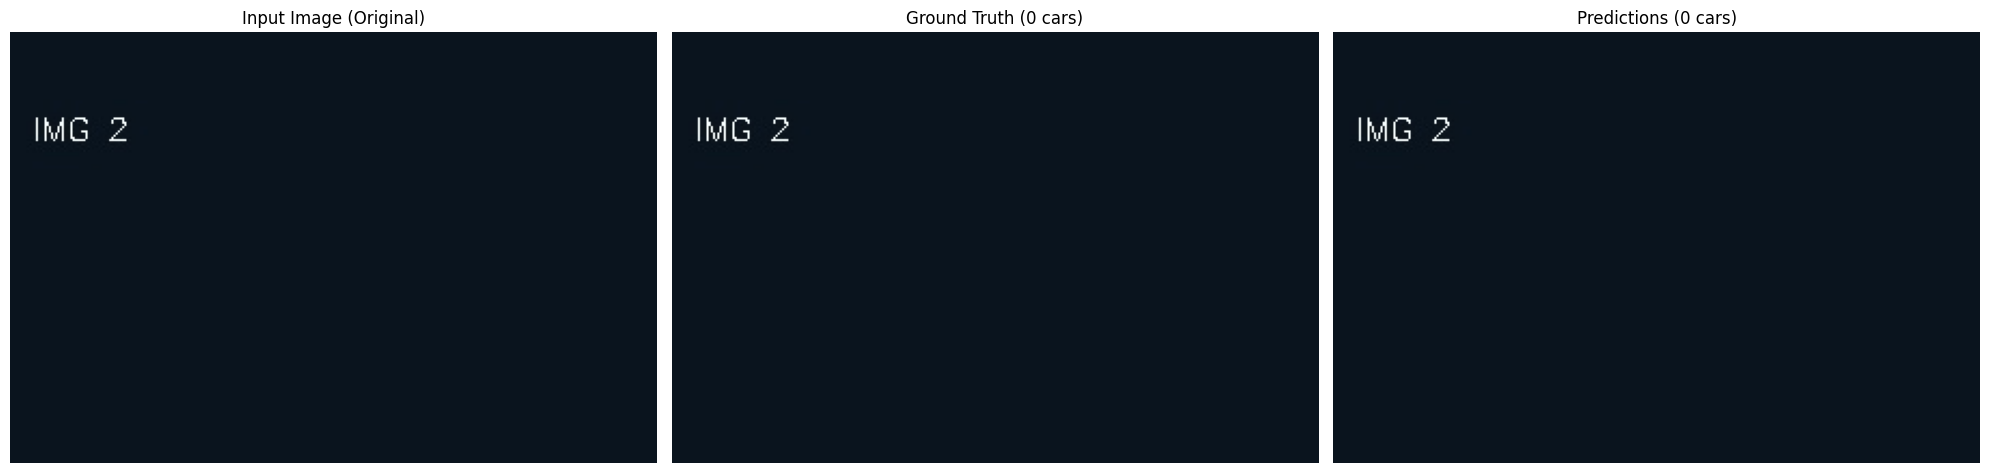


Test Image 2/10: example_image_13.jpg
Mode: Using original image example_image_13.jpg
  Image Stats: GT Cars=1, Predicted Cars=0
  Metrics: Seg Accuracy=0.972, Seg Precision=0.000, Count MSE=1


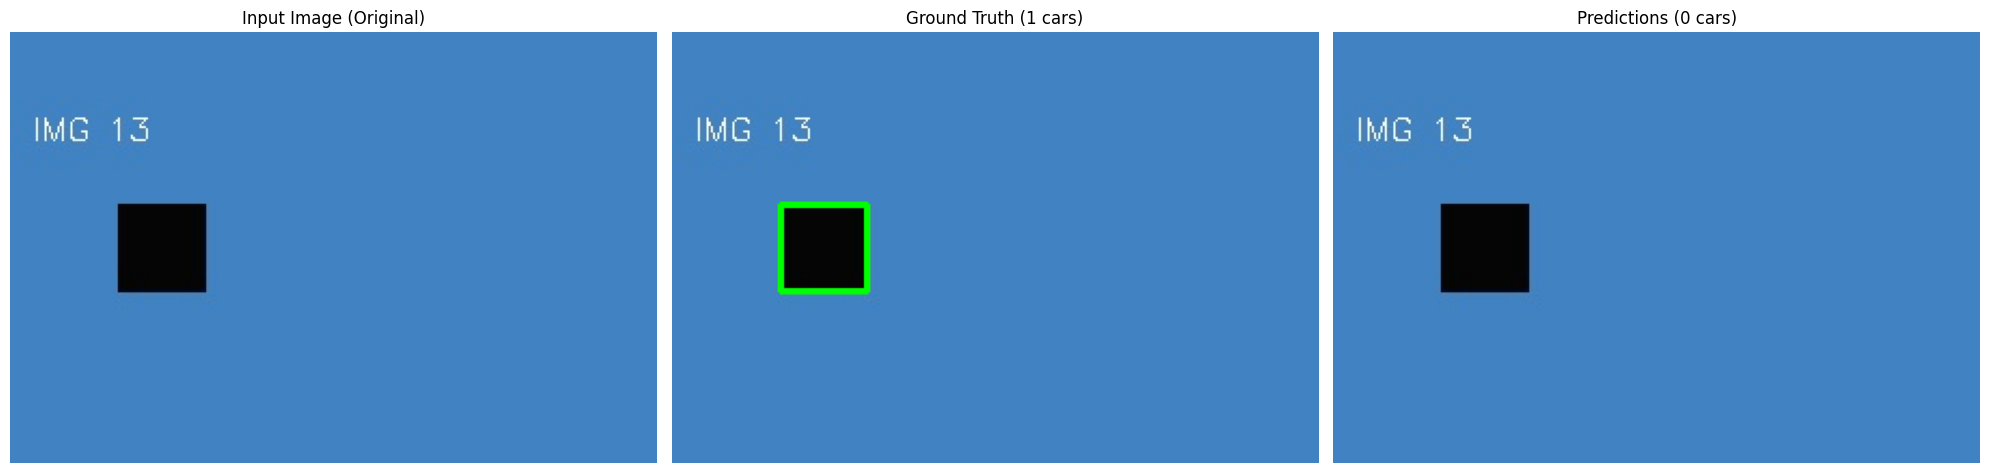


Test Image 3/10: example_image_8.jpg
Mode: Using original image example_image_8.jpg
  Image Stats: GT Cars=0, Predicted Cars=0
  Metrics: Seg Accuracy=1.000, Seg Precision=0.000, Count MSE=0


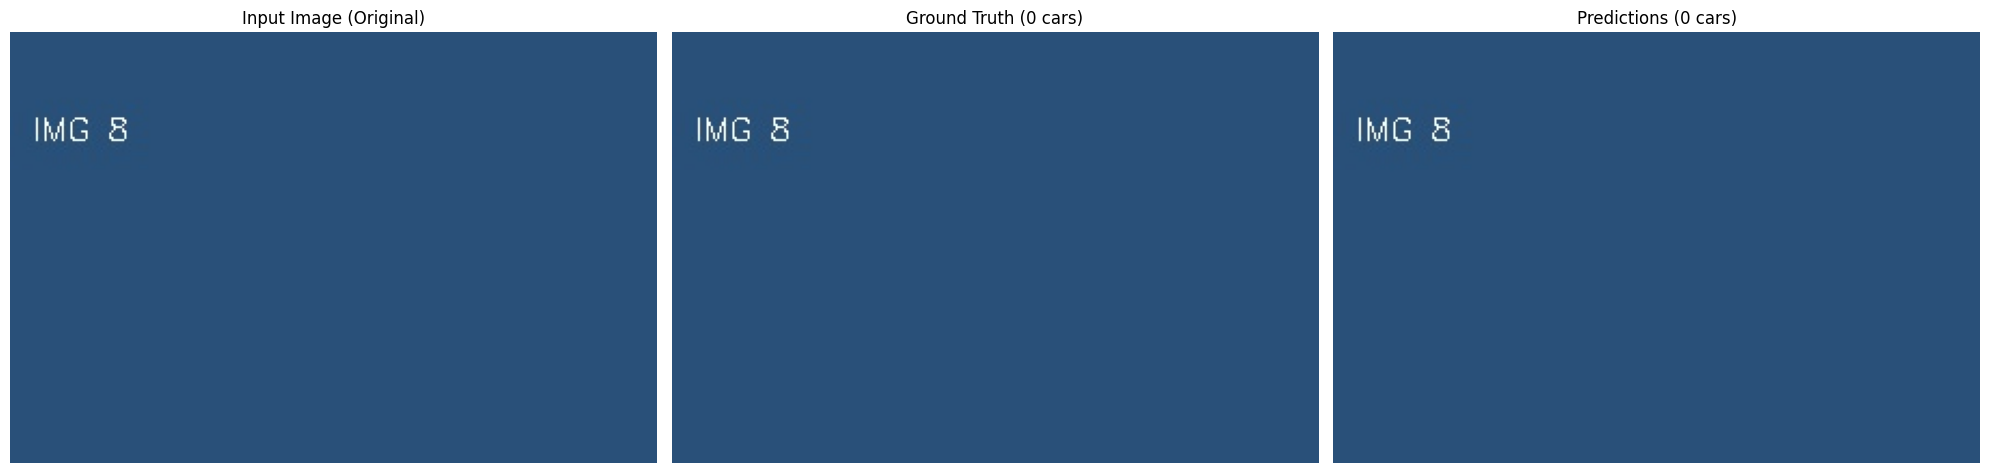


Test Image 4/10: example_image_3.jpg
Mode: Using original image example_image_3.jpg
  Image Stats: GT Cars=2, Predicted Cars=0
  Metrics: Seg Accuracy=0.930, Seg Precision=0.000, Count MSE=4


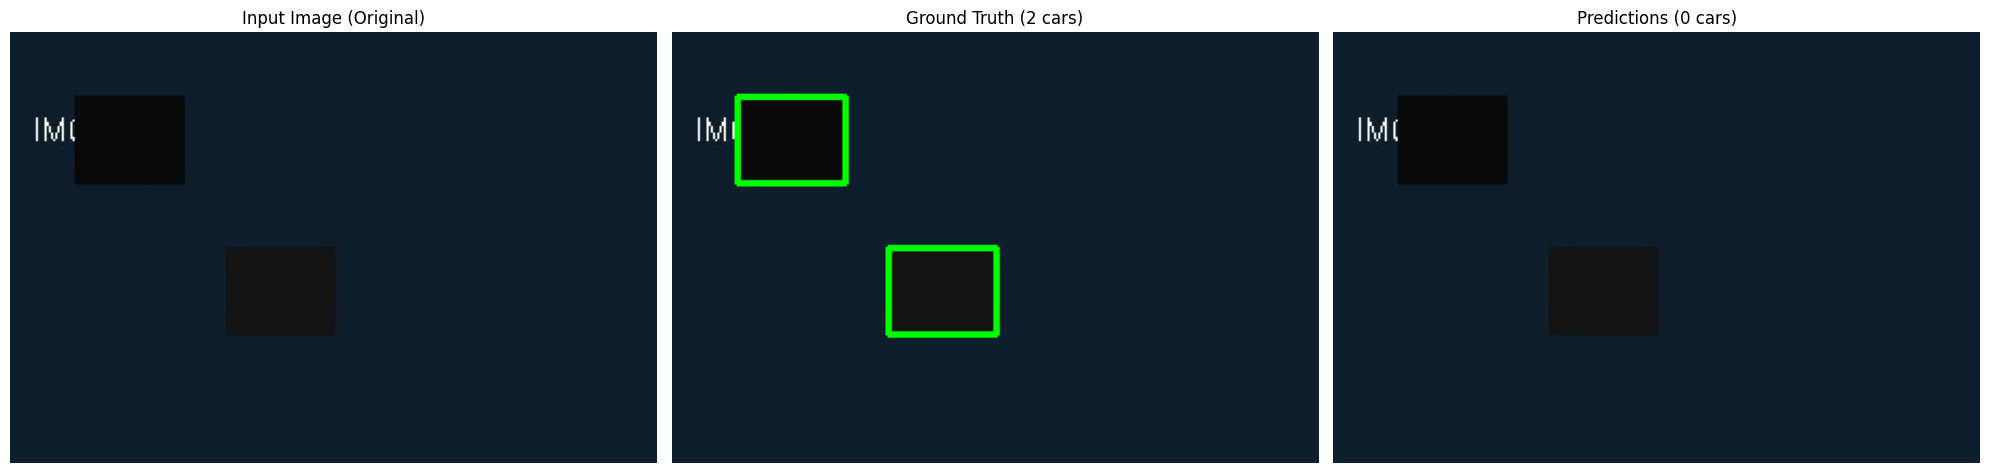


Test Image 5/10: example_image_7.jpg
Mode: Using original image example_image_7.jpg
  Image Stats: GT Cars=1, Predicted Cars=0
  Metrics: Seg Accuracy=0.972, Seg Precision=0.000, Count MSE=1


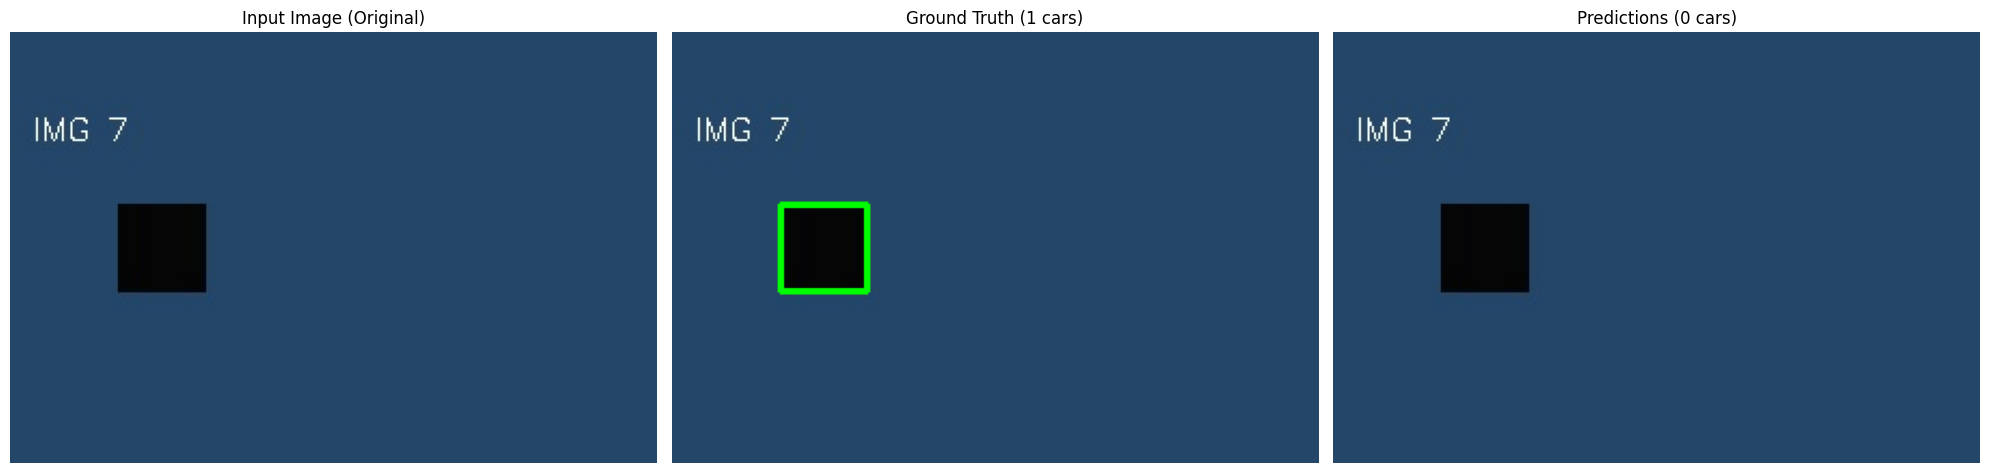


Test Image 6/10: example_image_5.jpg
Mode: Using original image example_image_5.jpg
  Image Stats: GT Cars=0, Predicted Cars=0
  Metrics: Seg Accuracy=1.000, Seg Precision=0.000, Count MSE=0


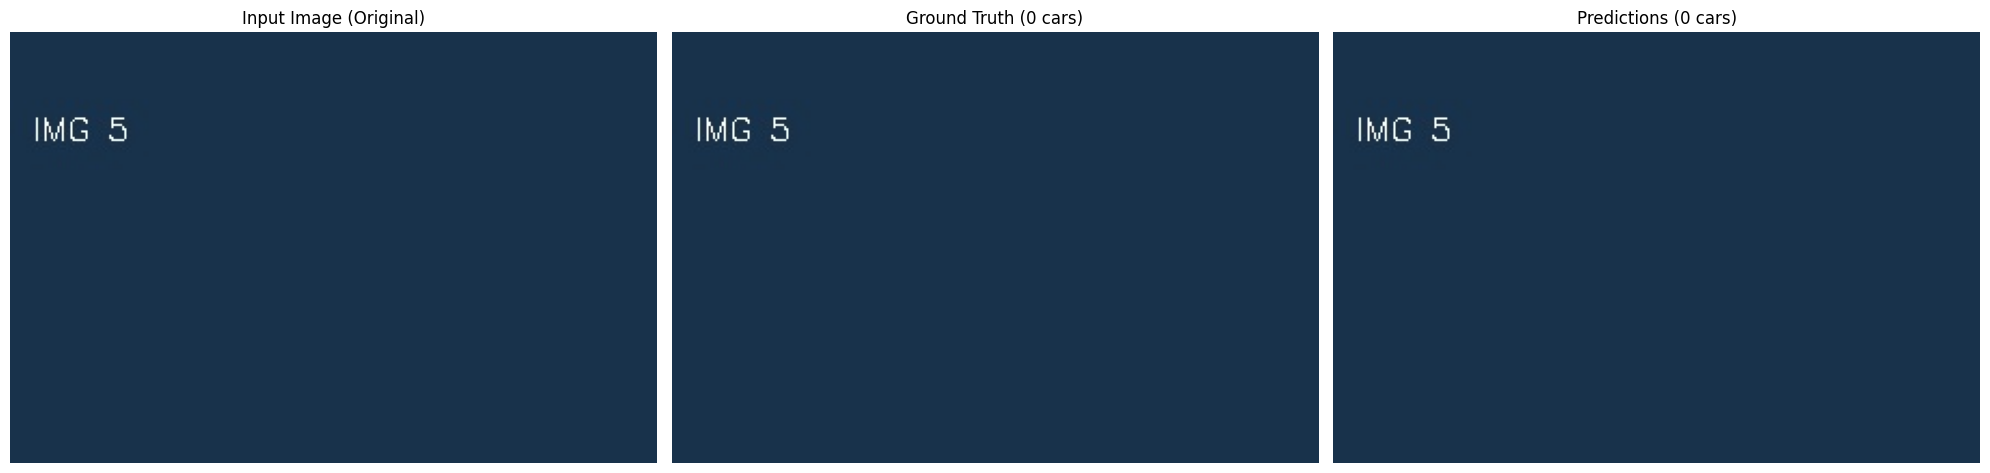


Test Image 7/10: example_image_14.jpg
Mode: Using original image example_image_14.jpg
  Image Stats: GT Cars=0, Predicted Cars=0
  Metrics: Seg Accuracy=1.000, Seg Precision=0.000, Count MSE=0


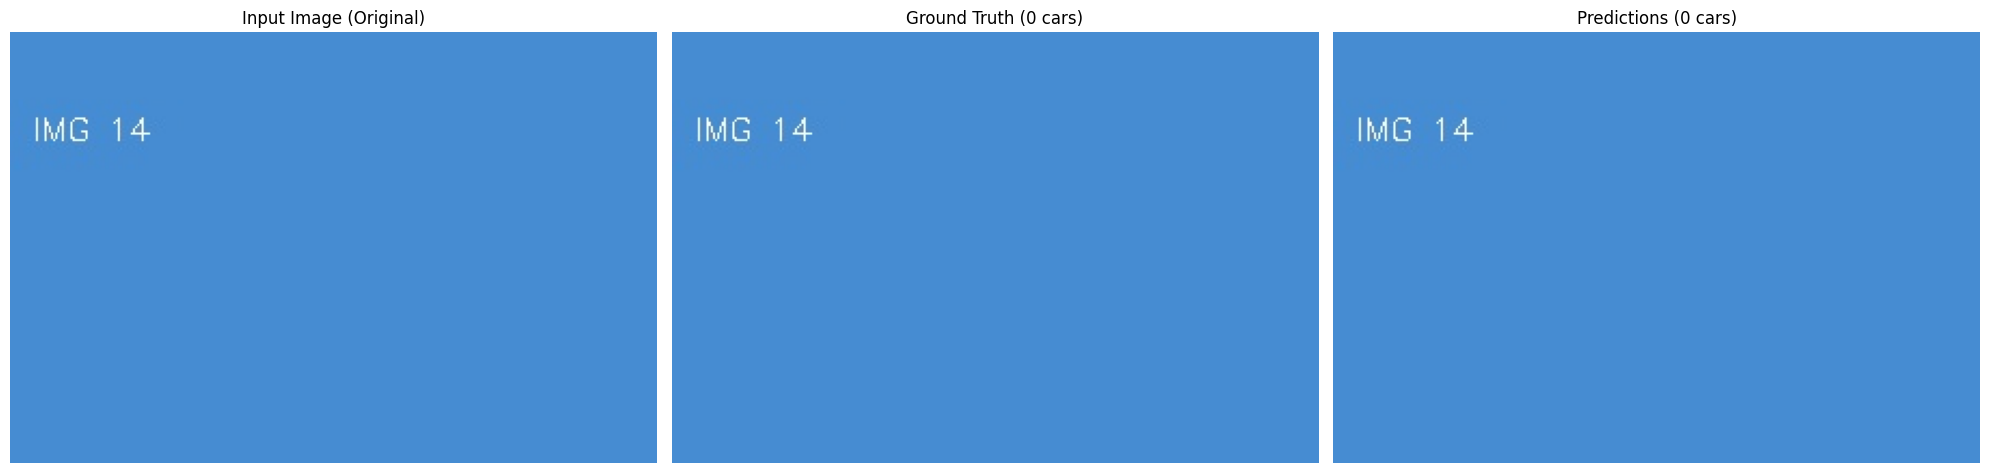


Test Image 8/10: example_image_9.jpg
Mode: Using original image example_image_9.jpg
  Image Stats: GT Cars=2, Predicted Cars=0
  Metrics: Seg Accuracy=0.930, Seg Precision=0.000, Count MSE=4


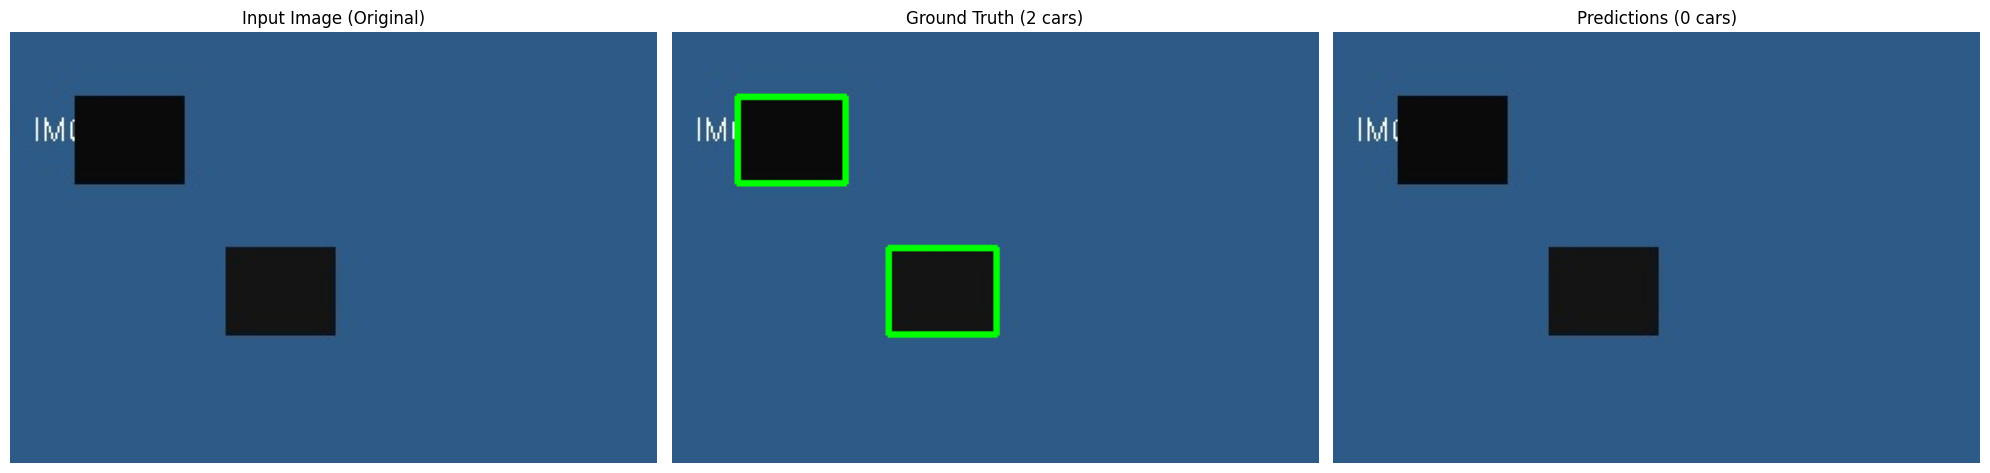


Test Image 9/10: example_image_12.jpg
Mode: Using original image example_image_12.jpg
  Image Stats: GT Cars=2, Predicted Cars=0
  Metrics: Seg Accuracy=0.930, Seg Precision=0.000, Count MSE=4


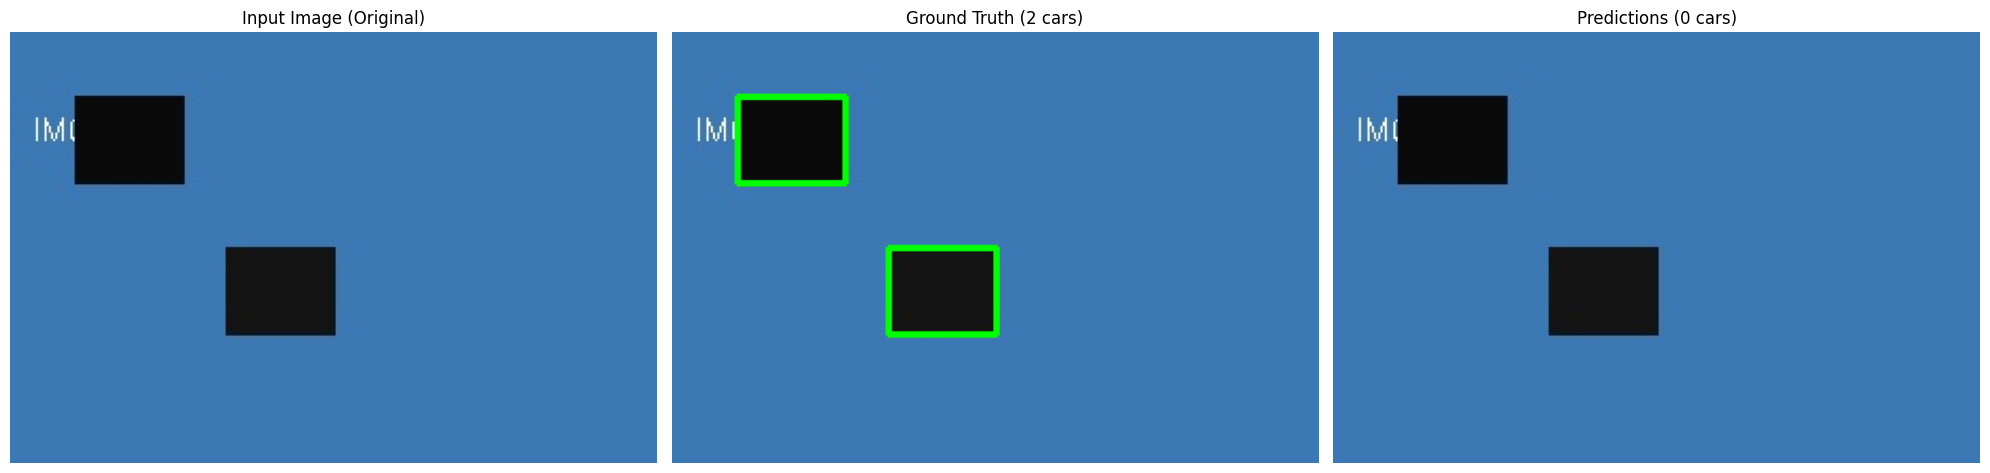


Test Image 10/10: example_image_10.jpg
Mode: Using original image example_image_10.jpg
  Image Stats: GT Cars=1, Predicted Cars=0
  Metrics: Seg Accuracy=0.972, Seg Precision=0.000, Count MSE=1


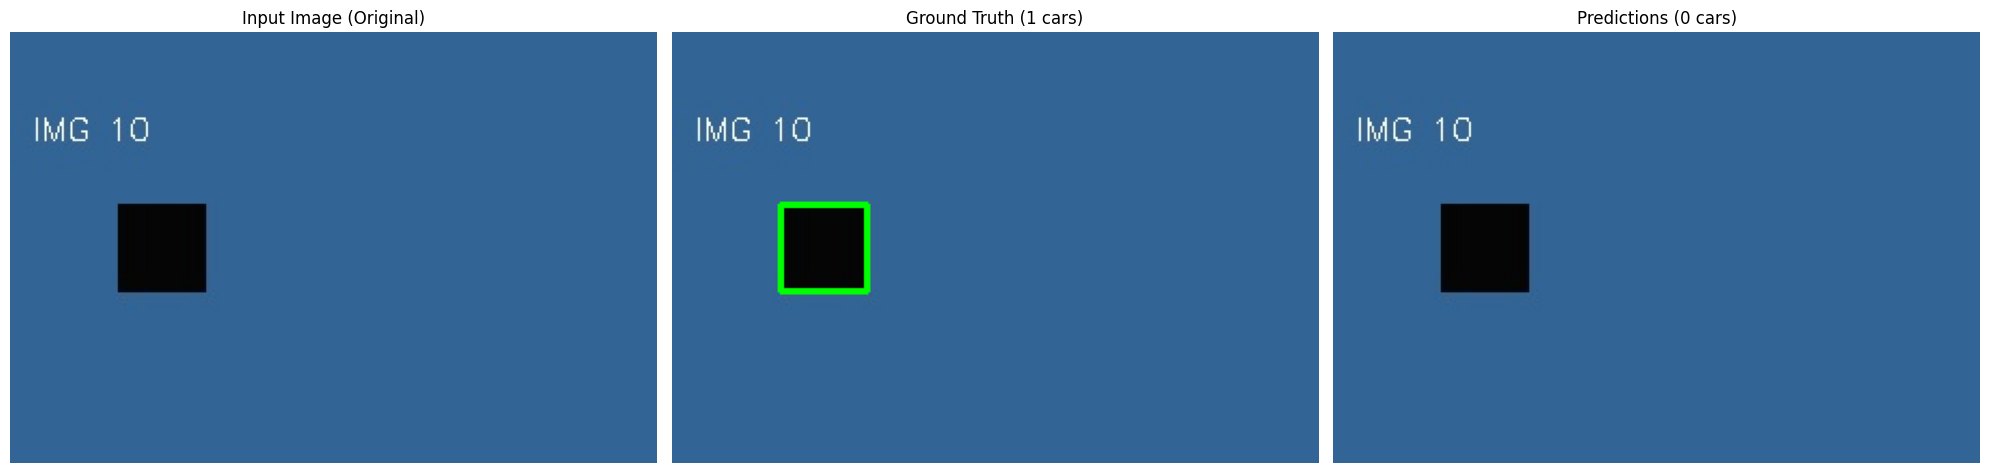

Average Segmentation Accuracy: 0.9707
Average Segmentation Precision: 0.0000
Average Vehicle Count MSE: 1.5000
Total GT Vehicles Across Test Set: 9
Total Predicted Vehicles Across Test Set: 0


In [63]:
if classifier_is_ready and source_files_for_testing_main and actual_num_test_images_main > 0:
    segmentation_accuracies = []
    segmentation_precisions = []
    count_mses = []
    grand_total_gt_vehicles = 0
    grand_total_pred_vehicles = 0

    for idx_test in range(actual_num_test_images_main):
        current_test_file_base = source_files_for_testing_main[idx_test]
        print(f"\nTest Image {idx_test+1}/{actual_num_test_images_main}: {current_test_file_base}")

        current_image_for_processing_bgr = None
        ground_truth_boxes_for_current_img = []

        if USE_SYNTHETIC_IMAGES_FOR_TESTING:
            print(f"Mode: Generating synthetic image from base {current_test_file_base}")
            current_image_for_processing_bgr, ground_truth_boxes_for_current_img = \
                vehicle_processor.generate_composite_image(current_test_file_base,
                                                           max_added_patches=NUM_PATCHES_MAX_SYNTHETIC,
                                                           max_obj_overlap=SYNTHETIC_IMAGE_MAX_OVERLAP_RATIO)
            if current_image_for_processing_bgr is None:
                print(f"Skipping: Failed to generate synthetic image from {current_test_file_base}.")
                continue
        else:
            print(f"Mode: Using original image {current_test_file_base}")
            img_path_original = os.path.join(IMAGES_DIR, current_test_file_base)
            current_image_for_processing_bgr = cv2.imread(img_path_original)
            if current_image_for_processing_bgr is None:
                print(f"Skipping: Failed to load original image {img_path_original}.")
                continue
            ann_path_original = os.path.join(ANNOTATIONS_DIR, current_test_file_base.rsplit('.',1)[0] + '.txt')
            if os.path.exists(ann_path_original):
                with open(ann_path_original, 'r') as ann_f_handle:
                    for line in ann_f_handle:
                        parts = line.strip().split(',')
                        if len(parts) >= 6 and int(parts[5]) == 4: # Vehicle
                            x,y,w,h = map(int, parts[:4])
                            ground_truth_boxes_for_current_img.append([x,y,x+w,y+h])
            else:
                 print(f"Note: No annotation file found for {current_test_file_base}, assuming 0 GT vehicles.")


        detected_rects, _, predicted_px_mask = \
            vehicle_processor.detect_vehicles_from_image(current_image_for_processing_bgr)

        img_h, img_w = current_image_for_processing_bgr.shape[:2]
        gt_px_mask = np.zeros((img_h, img_w), dtype=np.uint8)
        for gt_b in ground_truth_boxes_for_current_img:
            cv2.rectangle(gt_px_mask, (gt_b[0], gt_b[1]), (gt_b[2], gt_b[3]), 255, -1)

        tp_px = np.sum((gt_px_mask == 255) & (predicted_px_mask == 255))
        fp_px = np.sum((gt_px_mask == 0) & (predicted_px_mask == 255))
        fn_px = np.sum((gt_px_mask == 255) & (predicted_px_mask == 0))
        tn_px = np.sum((gt_px_mask == 0) & (predicted_px_mask == 0))

        current_accuracy = (tp_px + tn_px) / (img_h * img_w) if (img_h * img_w) > 0 else 0
        current_precision = tp_px / (tp_px + fp_px) if (tp_px + fp_px) > 0 else 0
        segmentation_accuracies.append(current_accuracy)
        segmentation_precisions.append(current_precision)

        gt_vehicle_count = len(ground_truth_boxes_for_current_img)
        labeled_predicted_mask_regions = skimage_label(predicted_px_mask, connectivity=1, background=0)
        predicted_vehicle_count = np.max(labeled_predicted_mask_regions)

        current_mse = (gt_vehicle_count - predicted_vehicle_count) ** 2
        count_mses.append(current_mse)
        grand_total_gt_vehicles += gt_vehicle_count
        grand_total_pred_vehicles += predicted_vehicle_count

        print(f"  Image Stats: GT Cars={gt_vehicle_count}, Predicted Cars={predicted_vehicle_count}")
        print(f"  Metrics: Seg Accuracy={current_accuracy:.3f}, Seg Precision={current_precision:.3f}, Count MSE={current_mse}")

        # Visualization
        fig_disp, axes_disp = plt.subplots(1, 3, figsize=(20, 7))
        axes_disp[0].imshow(cv2.cvtColor(current_image_for_processing_bgr, cv2.COLOR_BGR2RGB))
        axes_disp[0].set_title(f"Input Image ({'Synthetic' if USE_SYNTHETIC_IMAGES_FOR_TESTING else 'Original'})")
        axes_disp[0].axis('off')

        img_display_gt = current_image_for_processing_bgr.copy()
        for gt_b_vis in ground_truth_boxes_for_current_img:
            cv2.rectangle(img_display_gt, (gt_b_vis[0], gt_b_vis[1]), (gt_b_vis[2], gt_b_vis[3]), (0,255,0), 2)
        axes_disp[1].imshow(cv2.cvtColor(img_display_gt, cv2.COLOR_BGR2RGB))
        axes_disp[1].set_title(f"Ground Truth ({gt_vehicle_count} cars)")
        axes_disp[1].axis('off')

        img_display_pred = current_image_for_processing_bgr.copy()
        for pred_b_vis in detected_rects:
            cv2.rectangle(img_display_pred, (pred_b_vis[0], pred_b_vis[1]), (pred_b_vis[2], pred_b_vis[3]), (255,0,0), 2)
        axes_disp[2].imshow(cv2.cvtColor(img_display_pred, cv2.COLOR_BGR2RGB))
        axes_disp[2].set_title(f"Predictions ({predicted_vehicle_count} cars)")
        axes_disp[2].axis('off')
        plt.tight_layout()
        plt.show()

    if segmentation_accuracies:
        avg_seg_accuracy = np.mean(segmentation_accuracies)
        avg_seg_precision = np.mean(segmentation_precisions)
        avg_count_mse = np.mean(count_mses)
        print(f"Average Segmentation Accuracy: {avg_seg_accuracy:.4f}")
        print(f"Average Segmentation Precision: {avg_seg_precision:.4f}")
        print(f"Average Vehicle Count MSE: {avg_count_mse:.4f}")
        print(f"Total GT Vehicles Across Test Set: {grand_total_gt_vehicles}")
        print(f"Total Predicted Vehicles Across Test Set: {grand_total_pred_vehicles}")
    else:
        print("No images were processed during testing. Cannot compute average metrics.")

elif not source_files_for_testing_main or actual_num_test_images_main == 0:
    print("Evaluation skipped: No images available in the test set.")
else:
    print("Evaluation skipped: Classifier was not successfully trained.")